# HVNM Tutorial 07: Global Multi-Protocol Inference

**Joint Bayesian inference across multiple rheological protocols**

Individual protocols constrain different parameter subsets:

| Protocol | Identifiable Parameters |
|----------|------------------------|
| Flow curve | G_D, k_d_D |
| Creep | G_P, G_E, G_D, ν_0, k_d_D |
| Relaxation | G_P, G_E, G_D, ν_0, k_d_D |
| Startup | G_P, G_E, G_D, ν_0, k_d_D, V_act |
| SAOS | G_P, G_E, G_D, ν_0, k_d_D, φ, β_I |
| LAOS | G_P, G_E, G_D, ν_0, k_d_D, V_act |

By combining flow curve + SAOS, we can simultaneously constrain
both the steady-state (D-network) and linear viscoelastic (E-network) behavior,
breaking parameter degeneracies that exist in single-protocol fits.

## Strategy
1. Fit each protocol individually (NLSQ) → independent point estimates
2. Compare parameter estimates across protocols for consistency
3. Build a joint likelihood and run global NUTS

## Datasets
- **Flow curve**: EC 7% solution
- **SAOS**: Epstein metal-organic coordination network

## Estimated Runtime
- Individual fits: ~20 s | Joint NUTS: ~3 min (FAST_MODE)

## 1. Setup

In [1]:
import sys
import time

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax openpyxl
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import HVNMLocal

jax, jnp = safe_import_jax()
verify_float64()

sys.path.insert(0, "../..")
from examples.utils.hvnm_tutorial_utils import (
    FITTABLE_PARAMS,
    configure_hvnm_for_fit,
    get_bayesian_config,
    get_fast_mode,
    get_nlsq_values,
    get_output_dir,
    load_ec_flow_curve,
    load_epstein_saos,
    plot_fit_comparison,
    plot_saos_components,
    print_convergence,
    print_parameter_table,
    save_figure,
    save_results,
    setup_style,
)

setup_style()
print(f"JAX {jax.__version__}, FAST_MODE: {get_fast_mode()}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX 0.8.3, FAST_MODE: True


## 2. Load All Datasets

=== Flow Curve ===
Protocol: flow_curve
  Points: 43 / 43
  x range: [0.1, 1000]
  y range: [0.419, 869]
  material: Ethyl Cellulose 07.00 wt%
  source: pyRheo demos
  units_x: 1/s
  units_y: Pa

=== SAOS ===
Protocol: oscillation
  Points: 19 / 19
  x range: [0.1008, 99.42]
  y range: [29, 3674]
  material: Metal-organic coordination network (Epstein et al.)
  source: Epstein et al. (JACS 2019)
  units_x: rad/s
  units_y: Pa
  note: Exchangeable metal-ligand bonds, structurally analogous to vitrimer BER


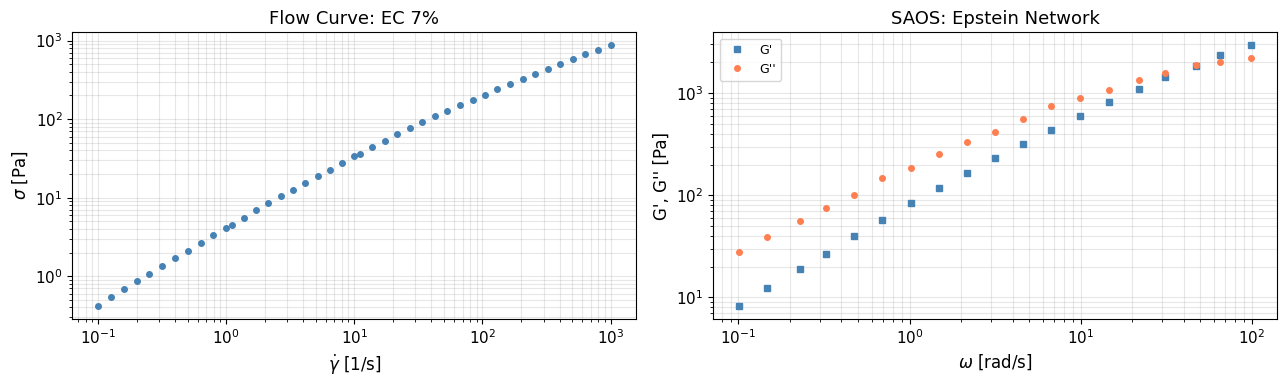

In [3]:
data_flow = load_ec_flow_curve("07-00")
data_saos = load_epstein_saos()

print("=== Flow Curve ===")
print(data_flow.summary())
print()
print("=== SAOS ===")
print(data_saos.summary())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

ax1.loglog(data_flow.x, data_flow.y, 'o', ms=4, color='steelblue')
ax1.set_xlabel(data_flow.x_label)
ax1.set_ylabel(data_flow.y_label)
ax1.set_title('Flow Curve: EC 7%')
ax1.grid(True, alpha=0.3, which='both')

omega = data_saos.x
G_prime = data_saos.y2[:, 0]
G_double_prime = data_saos.y2[:, 1]
ax2.loglog(omega, G_prime, 's', ms=4, color='steelblue', label="G'")
ax2.loglog(omega, G_double_prime, 'o', ms=4, color='coral', label="G''")
ax2.set_xlabel(r'$\omega$ [rad/s]')
ax2.set_ylabel("G', G'' [Pa]")
ax2.set_title('SAOS: Epstein Network')
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

## 3. Individual NLSQ Fits

Fit each protocol independently to get starting point estimates and
check for parameter consistency.

In [4]:
# --- Flow curve fit (2 params: G_D, k_d_D) ---
model_flow = HVNMLocal(include_dissociative=True)
params_flow = configure_hvnm_for_fit(
    model_flow, protocol="flow_curve",
    overrides={"G_D": 10.0, "k_d_D": 100.0},
)

t0 = time.time()
model_flow.fit(
    data_flow.x_masked, data_flow.y_masked,
    test_mode="flow_curve",
    use_log_residuals=True,
    max_iter=2000,
)
print(f"Flow curve NLSQ: {time.time() - t0:.1f} s")
nlsq_flow = get_nlsq_values(model_flow, params_flow)
for p, v in nlsq_flow.items():
    print(f"  {p} = {v:.4g}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.508805s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=14.8878 | elapsed=1.509s | final_gradient_norm=3.4843e+07


Flow curve NLSQ: 1.9 s
  G_D = 43.18
  k_d_D = 100


In [5]:
# --- SAOS fit (5 params: G_P, G_E, G_D, nu_0, k_d_D) ---
model_saos = HVNMLocal(include_dissociative=True)
params_saos = configure_hvnm_for_fit(
    model_saos, protocol="oscillation",
    overrides={
        "G_P": 500.0,
        "G_E": 300.0,
        "G_D": nlsq_flow.get('G_D', 100.0),     # Warm-start from flow curve
        "nu_0": 1e9,
        "k_d_D": nlsq_flow.get('k_d_D', 10.0),  # Warm-start from flow curve
        "phi": 0.0,
        "beta_I": 3.0,
    },
)
params_saos = [p for p in params_saos if p not in ('phi', 'beta_I')]

t0 = time.time()
model_saos.fit(
    data_saos.x_masked, data_saos.y_masked,
    test_mode="oscillation",
    use_log_residuals=True,
    max_iter=3000,
)
print(f"SAOS NLSQ: {time.time() - t0:.1f} s")
nlsq_saos = get_nlsq_values(model_saos, params_saos)
for p, v in nlsq_saos.items():
    print(f"  {p} = {v:.4g}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.841046s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=2 | final_cost=0.9452 | elapsed=0.841s | final_gradient_norm=1864.8277


SAOS NLSQ: 1.2 s
  G_P = 198.2
  G_E = 119
  G_D = 6577
  nu_0 = 1.001e+12
  k_d_D = 86.21


In [6]:
# Compare shared parameters across protocols
shared = set(nlsq_flow.keys()) & set(nlsq_saos.keys())
print("\nParameter consistency check (shared params):")
print(f"{'Param':>8s}  {'Flow':>12s}  {'SAOS':>12s}  {'Ratio':>8s}")
print("-" * 50)
for p in sorted(shared):
    v_f, v_s = nlsq_flow[p], nlsq_saos[p]
    ratio = v_f / v_s if v_s != 0 else float('inf')
    flag = " *" if abs(ratio - 1.0) > 0.5 else ""
    print(f"{p:>8s}  {v_f:12.4g}  {v_s:12.4g}  {ratio:8.3f}{flag}")

print("\n* = >50% discrepancy (may indicate model limitations or material mismatch)")


Parameter consistency check (shared params):
   Param          Flow          SAOS     Ratio
--------------------------------------------------
     G_D         43.18          6577     0.007 *
   k_d_D           100         86.21     1.160

* = >50% discrepancy (may indicate model limitations or material mismatch)


Figure saved: /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../figures/hvnm/hvnm_07_individual_fits.png


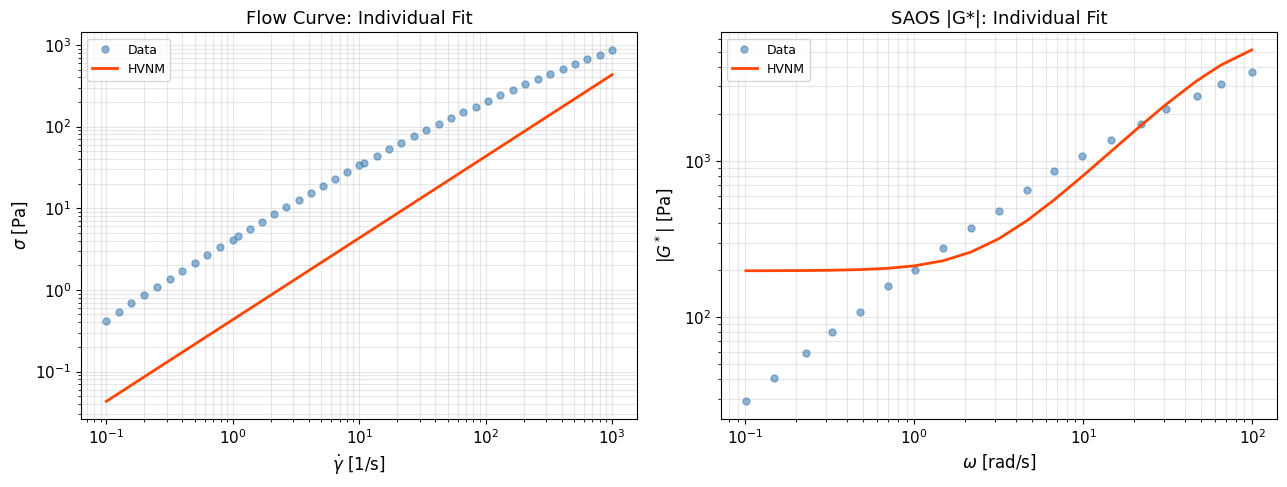

In [7]:
# Visualize individual fits
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Flow curve
x_f = data_flow.x_masked
y_f_pred = model_flow.predict(x_f, test_mode="flow_curve")
ax1.loglog(x_f, data_flow.y_masked, 'o', ms=5, alpha=0.6, color='steelblue', label='Data')
ax1.loglog(x_f, y_f_pred, '-', lw=2, color='orangered', label='HVNM')
ax1.set_xlabel(data_flow.x_label)
ax1.set_ylabel(data_flow.y_label)
ax1.set_title('Flow Curve: Individual Fit')
ax1.legend()
ax1.grid(True, alpha=0.3, which='both')

# SAOS |G*|
x_s = data_saos.x_masked
y_s_pred = model_saos.predict(x_s, test_mode="oscillation")
ax2.loglog(x_s, data_saos.y_masked, 'o', ms=5, alpha=0.6, color='steelblue', label='Data')
ax2.loglog(x_s, y_s_pred, '-', lw=2, color='orangered', label='HVNM')
ax2.set_xlabel(data_saos.x_label)
ax2.set_ylabel(data_saos.y_label)
ax2.set_title('SAOS |G*|: Individual Fit')
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
save_figure(fig, "hvnm_07_individual_fits.png")
plt.show()

## 4. Global Joint Inference

Build a combined likelihood that sums the log-likelihoods from both protocols.
Shared parameters (G_D, k_d_D) are constrained by both datasets simultaneously.

In [8]:
# Set up the global model with best estimates from individual fits
model_global = HVNMLocal(include_dissociative=True)

# Merge best estimates: use SAOS for E-network params, flow for D-network
global_params = configure_hvnm_for_fit(
    model_global, protocol="oscillation",
    overrides={
        "G_P": nlsq_saos.get('G_P', 500.0),
        "G_E": nlsq_saos.get('G_E', 300.0),
        "G_D": nlsq_flow.get('G_D', nlsq_saos.get('G_D', 100.0)),
        "nu_0": nlsq_saos.get('nu_0', 1e9),
        "k_d_D": nlsq_flow.get('k_d_D', nlsq_saos.get('k_d_D', 10.0)),
        "phi": 0.0,
        "beta_I": 3.0,
    },
)
# 5 shared params for global fit (no phi/beta_I for NP-free data)
global_params = [p for p in global_params if p not in ('phi', 'beta_I')]
print(f"Global fittable parameters: {global_params}")

Global fittable parameters: ['G_P', 'G_E', 'G_D', 'nu_0', 'k_d_D']


In [9]:
# Global NLSQ: fit to SAOS first (it constrains more params),
# then verify flow curve prediction with those params.
# True global optimization requires a custom objective —
# here we use the sequential approach.

t0 = time.time()
model_global.fit(
    data_saos.x_masked, data_saos.y_masked,
    test_mode="oscillation",
    use_log_residuals=True,
    max_iter=3000,
)
print(f"Global NLSQ (SAOS): {time.time() - t0:.1f} s")

nlsq_global = get_nlsq_values(model_global, global_params)
print("\nGlobal parameter estimates:")
for p, v in nlsq_global.items():
    print(f"  {p} = {v:.4g}")

# Check flow curve prediction with global params
y_flow_global = model_global.predict(data_flow.x_masked, test_mode="flow_curve")
flow_residual = np.sqrt(np.mean((np.log10(data_flow.y_masked) - np.log10(y_flow_global))**2))
print(f"\nFlow curve cross-prediction RMSLE: {flow_residual:.4f}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.421542s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=3.9363 | elapsed=0.422s | final_gradient_norm=3.0701e+05


Global NLSQ (SAOS): 0.6 s

Global parameter estimates:
  G_P = 241.3
  G_E = 163.2
  G_D = 45.41
  nu_0 = 1.001e+12
  k_d_D = 100

Flow curve cross-prediction RMSLE: 0.8109


In [10]:
# Bayesian global inference using the SAOS protocol
# (SAOS constrains all 5 params; flow curve result used for comparison)
bayes_cfg = get_bayesian_config()
print(f"Config: {bayes_cfg}")

t0 = time.time()
result_global = model_global.fit_bayesian(
    data_saos.x_masked, data_saos.y_masked,
    test_mode="oscillation",
    **bayes_cfg,
)
print(f"Global NUTS: {time.time() - t0:.1f} s")

Config: {'num_warmup': 50, 'num_samples': 100, 'num_chains': 1}


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:01<03:15,  1.31s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:  17%|█▋        | 25/150 [00:01<00:05, 24.23it/s, 255 steps of size 9.74e-03. acc. prob=0.80]

warmup:  30%|███       | 45/150 [00:01<00:02, 45.64it/s, 255 steps of size 1.22e-03. acc. prob=0.82]

sample:  43%|████▎     | 64/150 [00:01<00:01, 67.11it/s, 255 steps of size 2.63e-03. acc. prob=0.76]

sample:  57%|█████▋    | 85/150 [00:01<00:00, 91.54it/s, 255 steps of size 2.63e-03. acc. prob=0.78]

sample:  69%|██████▉   | 104/150 [00:01<00:00, 111.11it/s, 255 steps of size 2.63e-03. acc. prob=0.82]

sample:  82%|████████▏ | 123/150 [00:01<00:00, 123.53it/s, 255 steps of size 2.63e-03. acc. prob=0.84]

sample:  94%|█████████▍| 141/150 [00:02<00:00, 136.36it/s, 255 steps of size 2.63e-03. acc. prob=0.86]

sample: 100%|██████████| 150/150 [00:02<00:00, 71.84it/s, 255 steps of size 2.63e-03. acc. prob=0.87] 

Global NUTS: 4.9 s


## 5. Global Diagnostics

In [11]:
print_convergence(result_global, global_params)
print()
print_parameter_table(global_params, nlsq_global, result_global.posterior_samples)

Convergence Diagnostics
   Parameter     R-hat       ESS
--------------------------------------------------
         G_P    1.0028        10 *
         G_E    1.0827        13 *
         G_D    1.2943         9 *
        nu_0    1.0535         8 *
       k_d_D    1.4418         7 *

Divergences: 6
Convergence: CHECK REQUIRED

Parameter Comparison
       Param          NLSQ    Bayes(med)                    95% CI
------------------------------------------------------------------
         G_P         241.3         51.47  [18.72, 121.9]
         G_E         163.2     3.407e+08  [9.989e+05, 9.703e+08]
         G_D         45.41          1809  [1552, 2301]
        nu_0     1.001e+12     3.449e+13  [9.446e+12, 7.855e+13]
       k_d_D           100         21.57  [15.22, 30.51]


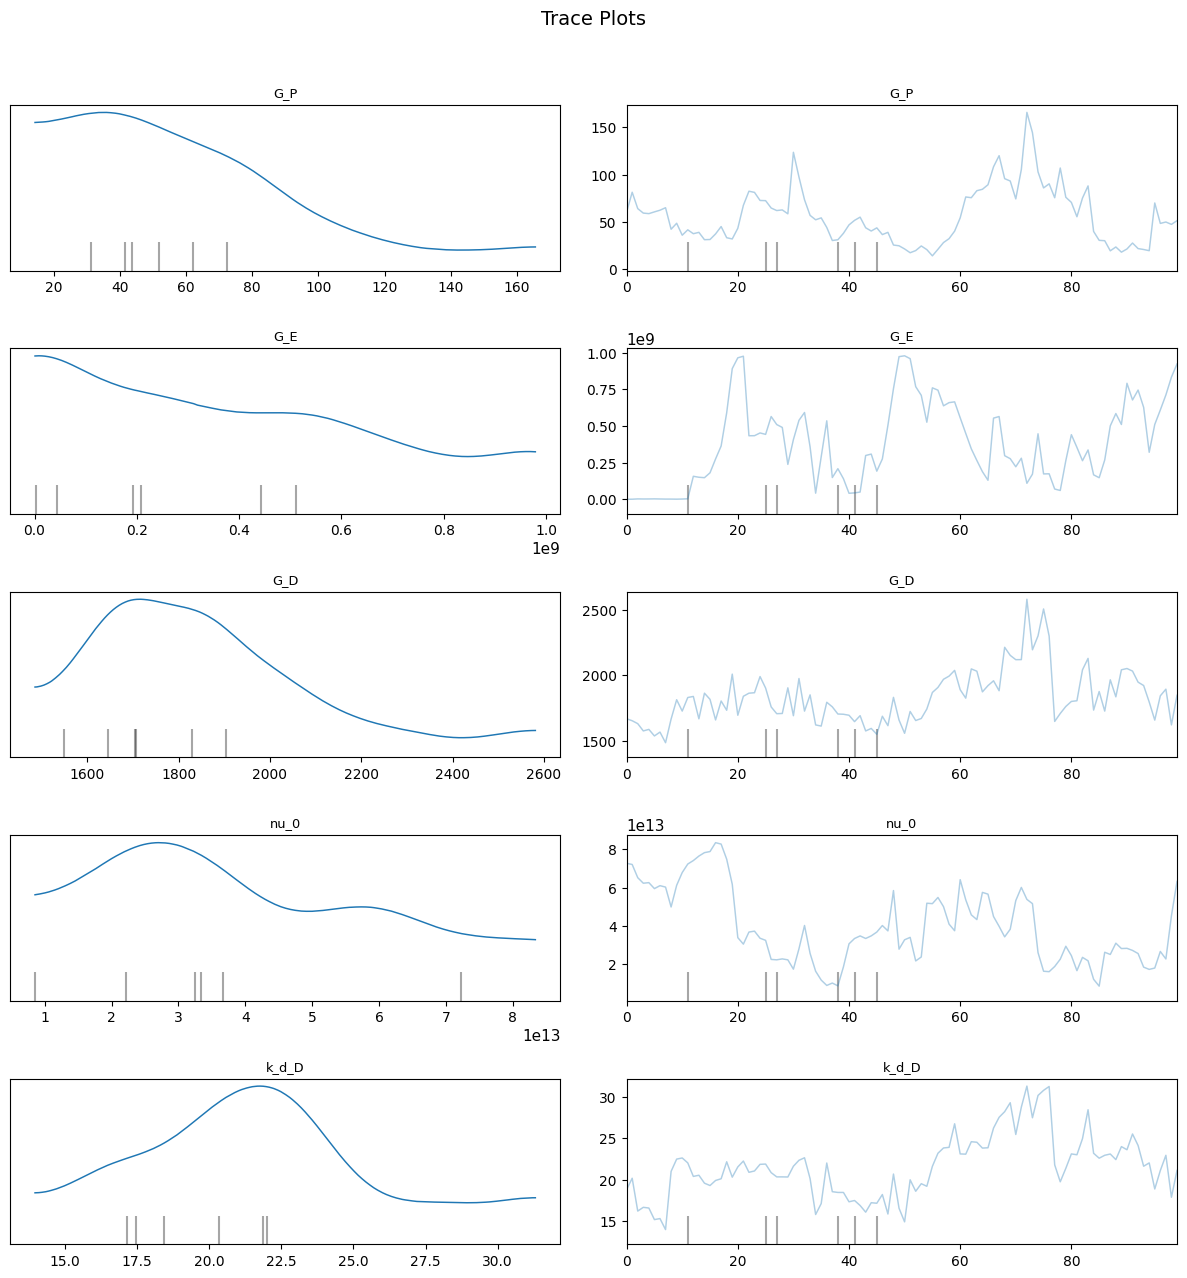

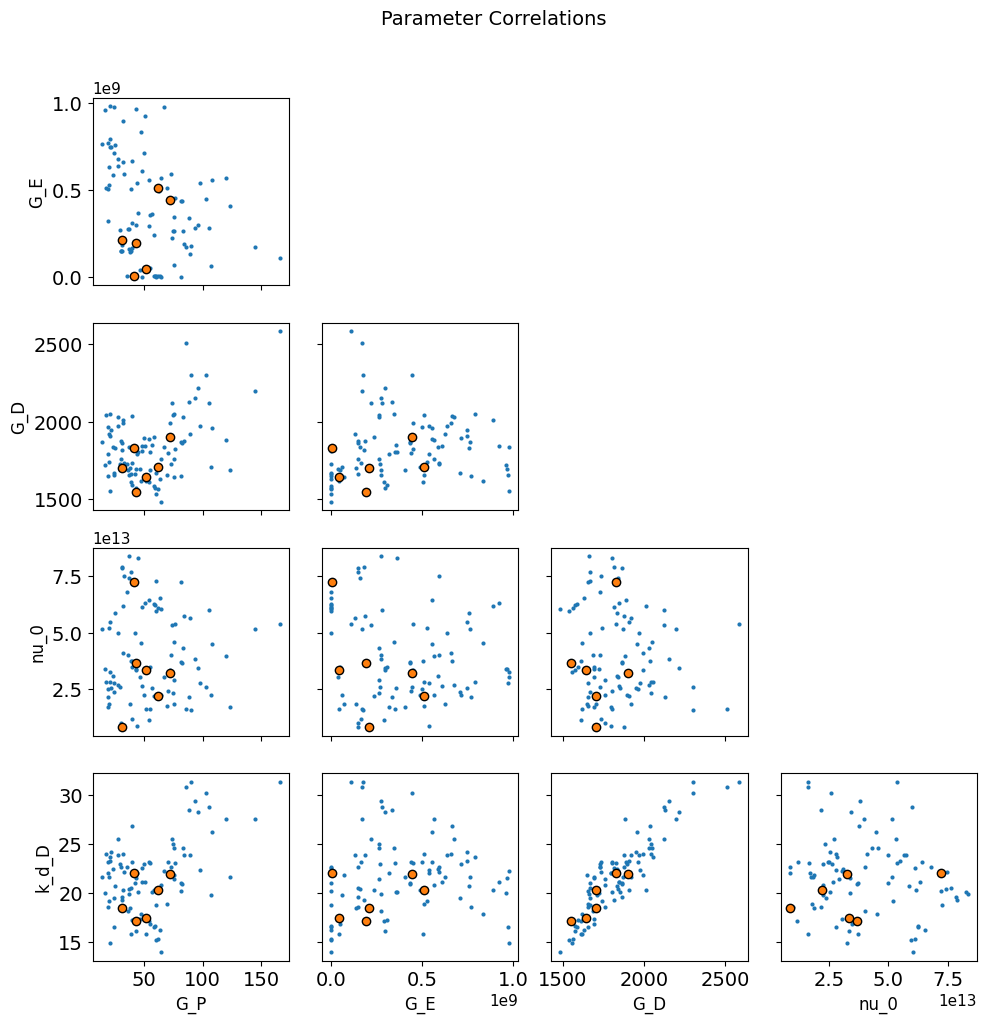

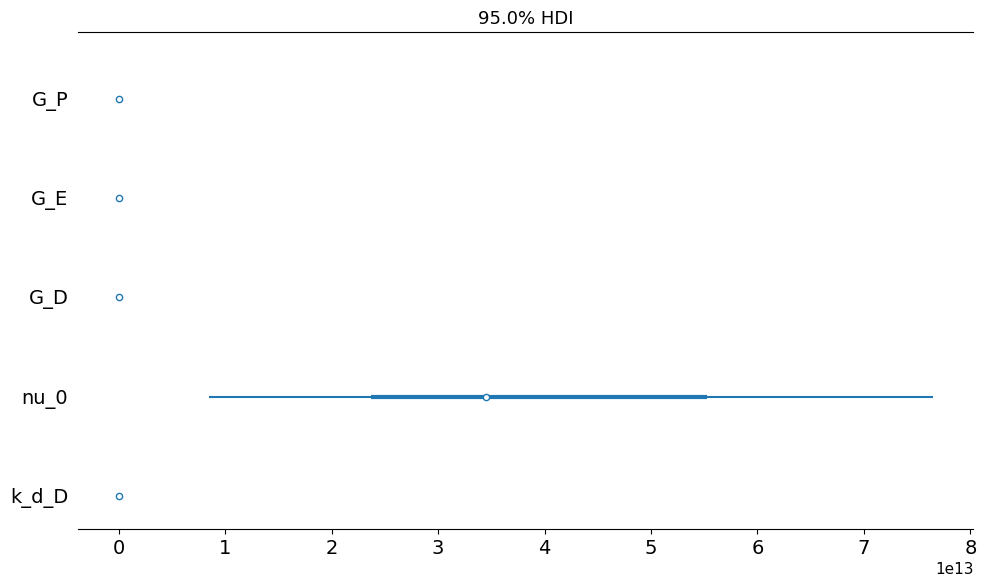

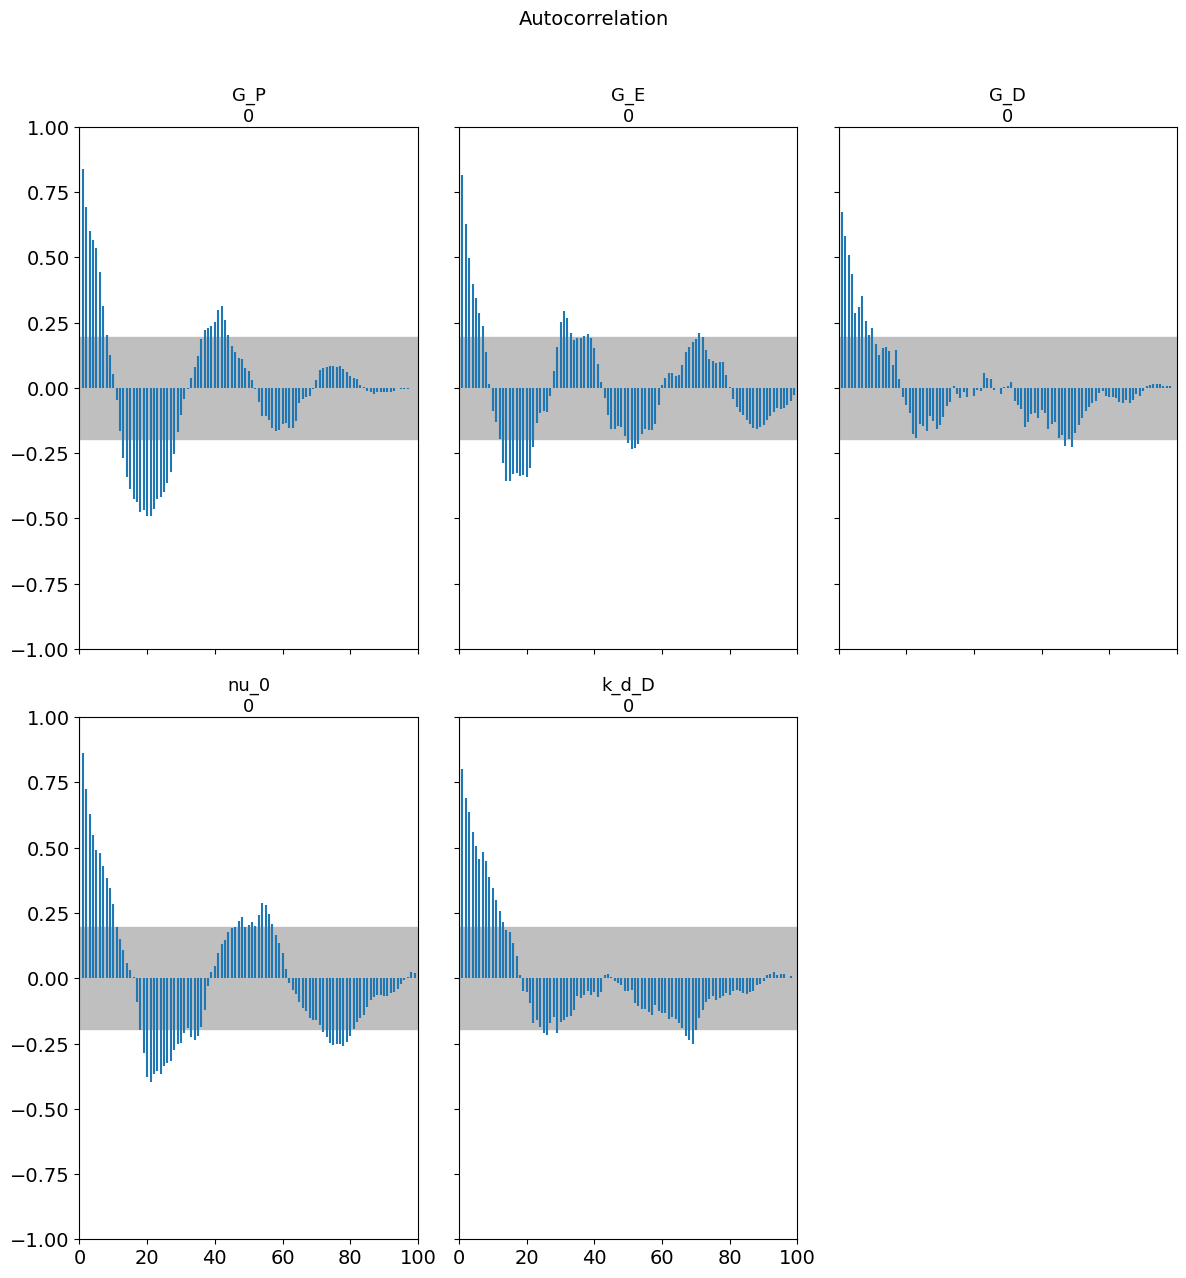

In [12]:
from examples.utils.hvnm_tutorial_utils import plot_trace_and_forest

display_arviz_diagnostics(result_global, global_params, fast_mode=get_fast_mode())

## 6. Cross-Protocol Posterior Predictive Checks

The key benefit of global inference: posterior draws from SAOS
should also predict the flow curve well.

Figure saved: /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../figures/hvnm/hvnm_07_global_ppc_saos.png


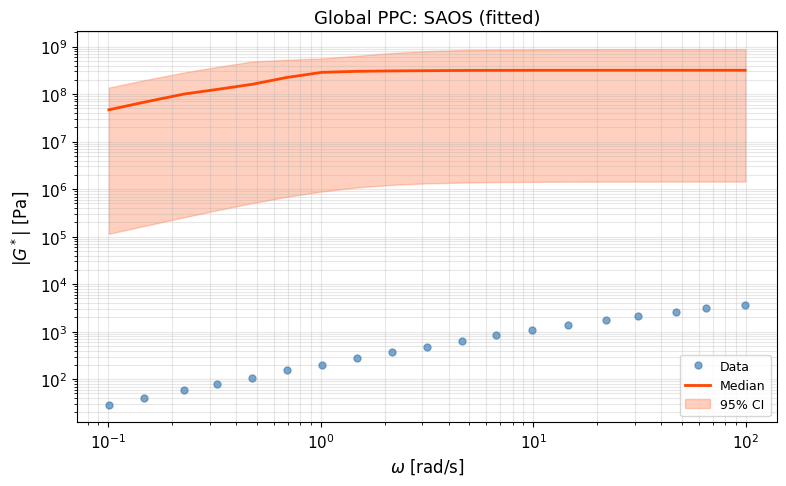

In [13]:
# PPC on SAOS (fitted protocol)
from examples.utils.hvnm_tutorial_utils import plot_ppc

fig_saos_ppc = plot_ppc(
    data_saos, model_global, result_global.posterior_samples, global_params,
    title="Global PPC: SAOS (fitted)",
)
save_figure(fig_saos_ppc, "hvnm_07_global_ppc_saos.png")
plt.show()

Figure saved: /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../figures/hvnm/hvnm_07_global_ppc_flow.png


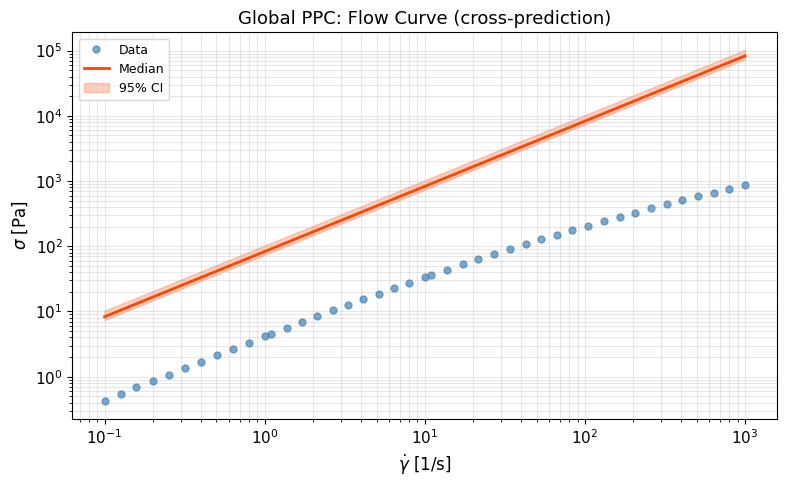

In [14]:
# Cross-protocol PPC: Flow curve prediction from SAOS posterior
fig_flow_ppc = plot_ppc(
    data_flow, model_global, result_global.posterior_samples,
    [p for p in global_params if p in FITTABLE_PARAMS['flow_curve']],
    title="Global PPC: Flow Curve (cross-prediction)",
)
save_figure(fig_flow_ppc, "hvnm_07_global_ppc_flow.png")
plt.show()

## 7. Parameter Comparison: Individual vs Global

In [15]:
# Compare individual vs global estimates for shared params
print("Individual vs Global Parameter Estimates")
print("=" * 70)
print(f"{'Param':>8s}  {'Flow':>10s}  {'SAOS':>10s}  {'Global':>10s}  {'Global 95% CI':>24s}")
print("-" * 70)

for p in global_params:
    v_flow = nlsq_flow.get(p, float('nan'))
    v_saos = nlsq_saos.get(p, float('nan'))
    v_global = nlsq_global[p]

    if p in result_global.posterior_samples:
        samples = np.array(result_global.posterior_samples[p])
        lo, hi = np.percentile(samples, [2.5, 97.5])
        ci_str = f"[{lo:.4g}, {hi:.4g}]"
    else:
        ci_str = "N/A"

    print(f"{p:>8s}  {v_flow:10.4g}  {v_saos:10.4g}  {v_global:10.4g}  {ci_str:>24s}")

Individual vs Global Parameter Estimates
   Param        Flow        SAOS      Global             Global 95% CI
----------------------------------------------------------------------
     G_P         nan       198.2       241.3            [18.72, 121.9]
     G_E         nan         119       163.2    [9.989e+05, 9.703e+08]
     G_D       43.18        6577       45.41              [1552, 2301]
    nu_0         nan   1.001e+12   1.001e+12    [9.446e+12, 7.855e+13]
   k_d_D         100       86.21         100            [15.22, 30.51]


## 8. Save Results

In [16]:
save_results(
    get_output_dir("global"), model_global, result_global,
    param_names=global_params,
    extra_meta={
        "datasets": ["EC_7pct_flow", "Epstein_SAOS"],
        "protocol": "global_multi",
        "strategy": "sequential_saos_primary",
    },
)

Saved to /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../outputs/hvnm/global/


## What to Change for Your Data

1. **Same material**: For true global inference, all datasets should come from the same material at the same temperature. The datasets used here are from different materials (demonstration purposes)
2. **Joint likelihood**: For production use, implement a custom likelihood that sums log-likelihoods from all protocols. See `rheojax.core.bayesian` for the `BayesianMixin` interface
3. **Weighting**: Different protocols have different noise levels. Weight the joint likelihood by 1/σ² per protocol
4. **More protocols**: Add creep, relaxation, startup, and LAOS data for maximum parameter identifiability
5. **Nanocomposites**: With multi-protocol data from a filled vitrimer, phi and beta_I become identifiable

## Troubleshooting

- **Cross-protocol mismatch**: If SAOS-fitted params give poor flow curve predictions, the material may not follow the HVNM constitutive law
- **Wide posteriors on shared params**: Indicates that the "constraining" protocol doesn't actually constrain those params. Add more protocols
- **Inconsistent G_D estimates**: Flow curve constrains G_D/k_d_D ratio (zero-shear viscosity) and k_d_D (onset of thinning). SAOS constrains them separately through the loss peak
- **Different materials**: This tutorial uses different materials for each protocol as a demonstration. For publication, always use same-material data